# Custom Datasets 
  
When we are using custom Datasets, we have to make it undergo some __preprocessing__ to make sure that the data is PyTorch readable.

In [35]:
import torch
from torch import nn

# Setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Getting Data

Our model starts with the __Food101__ dataset. This dataset has 101 different classes of food and a 1000 images per class.  
  
Our dataset starts with only 3 classes, with a 75:25 split on training and testing (~10% of the images)
So at first download the necessary data into the necessary directories. 

### Data Preparation and Data Exploration

#### Data transformation
Before we work with the image data:
1. First, we turn our target data into tensors.
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, where we call 'Dataset' and 'DataLoader'


In [36]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [37]:
import random
from PIL import Image
from pathlib import Path

# Setting up the path
data_path = Path('../../data')
image_path = data_path / "pizza_steak_sushi"

# Setting the seed
random.seed(42)

img_list = list(image_path.glob('*/*/*.jpg'))
random_image_choice = random.choice(img_list)

image_class = random_image_choice.parent.stem
img = Image.open(random_image_choice)

In [38]:
# Writing the transform function
img_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

img_transform(img)


tensor([[[0.2275, 0.2471, 0.3882,  ..., 0.5490, 0.5059, 0.4510],
         [0.2549, 0.3137, 0.4549,  ..., 0.5490, 0.4902, 0.4392],
         [0.3176, 0.4157, 0.5294,  ..., 0.5608, 0.5373, 0.5255],
         ...,
         [0.5882, 0.5804, 0.6549,  ..., 0.5490, 0.5373, 0.4706],
         [0.5490, 0.5725, 0.6275,  ..., 0.5647, 0.5490, 0.4941],
         [0.5098, 0.5373, 0.6078,  ..., 0.5647, 0.5412, 0.4980]],

        [[0.0745, 0.0706, 0.1216,  ..., 0.2078, 0.1569, 0.1098],
         [0.0745, 0.0863, 0.1569,  ..., 0.1961, 0.1412, 0.1020],
         [0.0824, 0.1255, 0.1843,  ..., 0.2000, 0.1882, 0.1804],
         ...,
         [0.2392, 0.2549, 0.3569,  ..., 0.2549, 0.2196, 0.1294],
         [0.1804, 0.2235, 0.2980,  ..., 0.2392, 0.2118, 0.1412],
         [0.1333, 0.1843, 0.2824,  ..., 0.2275, 0.1882, 0.1294]],

        [[0.0627, 0.0471, 0.0706,  ..., 0.0980, 0.0902, 0.0706],
         [0.0627, 0.0549, 0.0824,  ..., 0.0784, 0.0588, 0.0510],
         [0.0549, 0.0706, 0.0941,  ..., 0.0667, 0.0745, 0.

In [39]:
train_dir = image_path / "train"
train_data = datasets.ImageFolder(root=train_dir, transform=img_transform, 
                                  target_transform=None)

test_dir = image_path / "test"
test_data = datasets.ImageFolder(root=test_dir, transform=img_transform,
                                 target_transform=None)

test_data, train_data

(Dataset ImageFolder
     Number of datapoints: 75
     Root location: ../../data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 225
     Root location: ../../data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

#### Using DataLoaders
We use dataloaders to change our data into iterables so that they can be iterated batch wise.

In [40]:
import os
os.cpu_count()

12

In [41]:
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True, num_workers=1)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=True, num_workers=1)

len(train_dataloader), len(test_dataloader)

(8, 3)

#### Creating a custom dataset class
All custom datasets usually subclass `torch.utils.data.Dataset`  
  
Here what we would like to do is: 
1. Load images from a file
2. Want to be able to get class names from the directory
3. Add class names to a particualar dictionary


__Creating a helper function to rework pre-existing functions__

Now we create a helper function to return us the class names. We want it to do the following:
1. Scan the directory using `os.scandir()` and search for the required directories
2. Return an error message if the directory does not exist
3. Assign the classes to a dictionary

In [42]:
target_directory = train_dir
print(f"Target Directory: {target_directory}")

# Getting the names of the directories
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target Directory: ../../data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [43]:
# Now to create the actual helper function

def find_classes(directory: str) -> tuple[list[str], dict[str, int]]:
    """Basically does what was shown earlier"""
    target_directory = directory
    class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory)) if entry.is_dir()])
    
    if not class_names_found:
        raise FileNotFoundError("Couldn't find any classes in the directory")
    
    
    class_dict = {class_names:i for i, class_names in enumerate(class_names_found)}
        
    return class_names_found, class_dict

#find_classes(train_dir)

In [54]:
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [55]:
import pathlib

class ImageFolderCustom(Dataset):
    def __init__(self, directory: str, transform=None, target_transform=None):
        self.paths = list(pathlib.Path(directory).glob('*/*.jpg'))
        
        self.transform = transform
        self.target_transform = target_transform
        
        self.class_names, self.class_dict = find_classes(directory)
        
    def load_image(self, index:int) -> Image.Image:
        """Opens image via a path and returns it"""
        image_path = self.paths[index]
        return Image.open(image_path)
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index) -> tuple[torch.Tensor, int]:
        image_path = self.paths[index]
        image_class = image_path.parent.stem
        class_index = self.class_dict[image_class]
        
        img = Image.open(image_path)
        
        if self.transform:
            img = self.transform(img)
            
        if self.target_transform:
            class_index = self.target_transform(class_index)
            
        return img, class_index

train_data_custom = ImageFolderCustom(directory=str(train_dir), transform=train_transform)
test_data_custom = ImageFolderCustom(directory=str(test_dir), transform=test_transform)
len(train_data_custom)
#train_data_custom.__getitem__(2)


225

#### Creating a helper function to do the following:
1. Take in a Dataset and a number of parameters such as class names and how many images to display
2. To prevent display from getting out of hand, to cap the number of images at 10
3. Set a random seed for reproducibility
4. Get a list of random sample indexes from the dataset
5. Setup a matplotlib plot
6. Loop through the random sample images and plot with matplotlib

In [49]:
import matplotlib.pyplot as plt

def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: list[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # Display limiter
    if n > 10:
        n = 10
        display_shape = False
        print("For display purposes, number of images shown has been restricted to 10.")
    
    # Random Seed Generator
    if seed:
        random.seed(seed)
    
    # Getting random samples
    get_random_samples = random.sample(range(len(dataset)), k=n)
    
    plt.figure(figsize=(16,8))
    for i, targ_sample in enumerate(get_random_samples):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        
        targ_image_adjust = targ_image.permute(1, 2, 0)
        plt.subplot(1, n, i+1)
        plt.imshow((targ_image_adjust))
        plt.axis('off')
        
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape = {targ_image_adjust.shape}"
        
        plt.title(title)
        
        

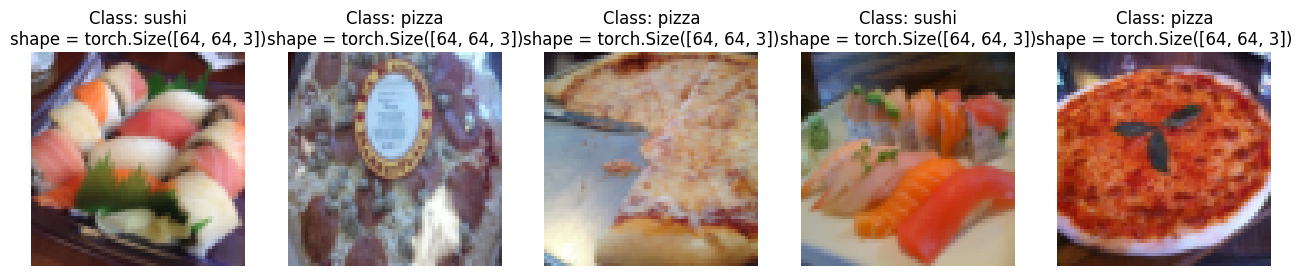

In [53]:
display_random_images(train_data_custom, train_data_custom.class_names, n=5, seed=42)

### Turn the dataset into DataLoader

In [56]:
BATCH_SIZE = 32
custom_train_dataoader = DataLoader(train_data_custom, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
custom_test_dataloader = DataLoader(test_data_custom, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

custom_test_dataloader, custom_train_dataoader

(<torch.utils.data.dataloader.DataLoader at 0x7588875f96c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7588875d3a30>)

### Data Augmentation
We can use a number of transforms to augment our data to artificially increase the number of data samples as we shall see below

In [57]:
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = test_transform                         # Just to include it here. No particular purpose


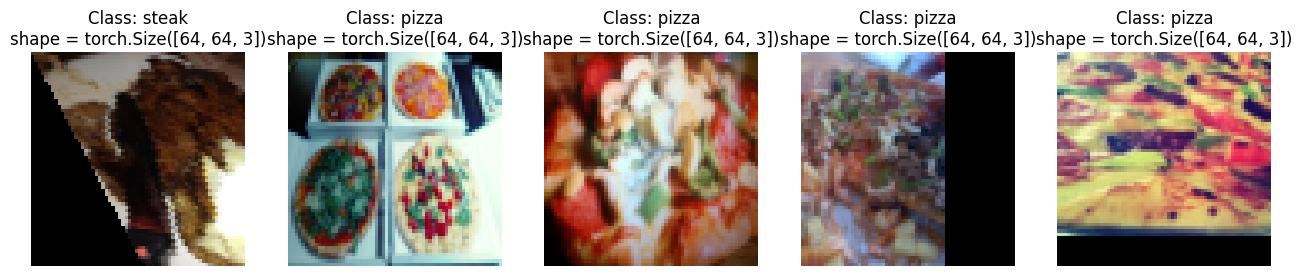

In [63]:
train_data_custom = ImageFolderCustom(directory=str(train_dir), transform=train_transform)
display_random_images(train_data_custom, train_data_custom.class_names, n=5)
